What this notebook does:

To evaluate the quality of the topics in the 5-topic LDA model('./LDA_Fitting/LDA_onreviews_nouns_withhptuning.ipynb'), I assess whether words in the same topic tend to be located in the same paragraphs as opposed to being mixed evenly in the review. Since paragraphs are used to separate the main ideas in a review, alignment of paragraphs with different topics would suggest that review writers associate the words in a topic with a particular set of ideas. 

I computed the LDA topic score for each multi-sentence (at least 4) paragraph.  If for each topic, the topic score for 4 sentence paragraphs has peaks at 0 and 1, then the topics align with the writers definition of a sentence. 

This was not actually the case. For each topic, most pargraphs in multiparagraph reviews have <0.5 topic importance.

In [ ]:
#Step one directory up to access the yelp scraping function in the helper_functions module
import os
print(os.getcwd())
os.chdir('../')
os.getcwd()

In [2]:
import numpy as np
import pandas as pd


import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
#import en_core_web_sm

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import gensim
from gensim.test.utils import datapath
from gensim.models import LdaModel
from gensim import corpora



In [4]:
shops = pd.read_csv('./ProcessedData/coffeeshops_withcfcutoff.csv')
reviews = pd.read_csv('./ProcessedData/allreviews_txtprocessed.csv')
reviews.rename(columns = {'rating':'review_rating'},inplace=True)
merged = pd.merge(shops,reviews,how='inner',on = ['alias'])
merged.head(3)

,id,name,alias,is_closed,review_count,price,rating,transactions,latitude,longitude,...,numcoffeemen,numreviews,fraccof,name_top5count,reviewidx,shopidx,date,review_rating,reviewtxt,mreviewtxt
0,DxeD4Jw3gsImI-olCOB0bA,Little Canal,little-canal-new-york-2,False,115,$,4.0,"['pickup', 'delivery']",40.714309,-73.990417,...,31.0,40,0.775,other,5244,102,2020-03-11,4.0,It smells good in here. Because it smells like...,it smells good in here. because it smells like...
1,DxeD4Jw3gsImI-olCOB0bA,Little Canal,little-canal-new-york-2,False,115,$,4.0,"['pickup', 'delivery']",40.714309,-73.990417,...,31.0,40,0.775,other,5245,102,2020-02-28,5.0,"Full disclosure, I've never sat in or ordered ...",full disclosure i've never sat in or ordered ...
2,DxeD4Jw3gsImI-olCOB0bA,Little Canal,little-canal-new-york-2,False,115,$,4.0,"['pickup', 'delivery']",40.714309,-73.990417,...,31.0,40,0.775,other,5246,102,2019-12-19,5.0,Just moved to the area and although there are ...,just moved to the area and although there are ...


### Breaking up reviews into paragraphs

In [7]:
plist = []
ridxlist = []
for reviewidx,review in zip(merged.reviewidx.to_list(),merged.reviewtxt.to_list()):
    splitrev = review.split('\n')
    plist.extend(splitrev)
    ridxlist.extend([reviewidx for i in range(len(splitrev))])

In [8]:
#Create a data frame with the review identities and the paragraph text.
#Go through list of raw text of reviews, if there is a newline \n split the review and append to a larger list. 
#Keep track of the review identity with a separate list.

pardf = pd.DataFrame(plist)
pardf['reviewidx'] = ridxlist
pardf.rename(columns={0:"partxt"},inplace=True)
pardf.head(5)
pardf['parlen'] = pardf.partxt.str.len()

,partxt,reviewidx,parlen
0,It smells good in here. Because it smells like...,5244,291
2,Little Canal has been here for four years and ...,5244,253
3,"Full disclosure, I've never sat in or ordered ...",5245,727
5,"Again, I know nothing about their food or eat-...",5245,89
6,Just moved to the area and although there are ...,5246,111


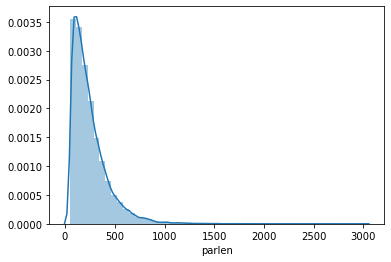

In [9]:
pardf = pardf[pardf.parlen>50]
sns.distplot(pardf.parlen)
pardf.parlen.min()
pardf.head(5)

In [10]:
#Now count the number of paragraphs per review
parnum = pardf.groupby(['reviewidx']).count()

In [11]:
parnum[parnum.parlen>1].shape
parnum.reset_index(inplace=True)
parnum.head(1)

,reviewidx,partxt,parlen
0,60,3,3


In [12]:
parnum.shape
print(pardf.head(1))
parnum.head(1)

                                              partxt  reviewidx  parlen
0  It smells good in here. Because it smells like...       5244     291


,reviewidx,partxt,parlen
0,60,3,3


### Only considering pargraphs in multiparagraph reviews

In [13]:

multipardf = parnum.loc[parnum.parlen>1,['reviewidx']]
multipardf.reviewidx.max()
multipardf.columns
multipardf = pardf.merge(multipardf,how='right',on='reviewidx')

In [14]:
multipardf.shape

(28883, 3)

### Lemmatizing and getting topic importances for the review paragraphs

In [15]:

dictionary = gensim.corpora.Dictionary.load('dictionary_allreviews_nouns.gensim')
corpus = pickle.load(open('corpus_allreviews_nouns.pkl', 'rb'))

temp_file = datapath("lda_nounsonly_5topics.gensim")
lda = gensim.models.ldamodel.LdaModel.load(temp_file)

In [32]:
#Process the paragraphs that belong to multiparagraph reviews
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = multipardf.partxt.values.tolist()
data_words = list(sent_to_words(data))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','good','great','love','go','always','go','order','get','say','try','nice','need','order','really','also','but','starbuck','dunkin','gregory','pret','bluestone','la colombe',
                  'starbucks','gregorys','store','area','people','location','drink'])

#'time','place','shop'
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#we only focus on nouns and verbs since they probably provide the most distinct topic information
def lemmatization(texts, allowed_postags=['NOUN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_lg", disable=['parser', 'ner'])
#nlp = en_core_web_lg.load()
# Do lemmatization keeping only nouns
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])

import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thomasyoung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
ldavecs = []
for i in range(len(data_lemmatized)):
    corpus = dictionary.doc2bow(data_lemmatized[i])
    ldav = lda[corpus][0]
    ldavecs.append([pair[1] for pair in ldav])
ldavecdf = pd.DataFrame(ldavecs)
ldavecdf.columns = ['t0','t1','t2','t3','t4']

In [51]:
multipardf = pd.concat([multipardf,ldavecdf],axis=1)
multipardf.tail(10)

### Visualizing the topic distribution for multiparagraph reviews

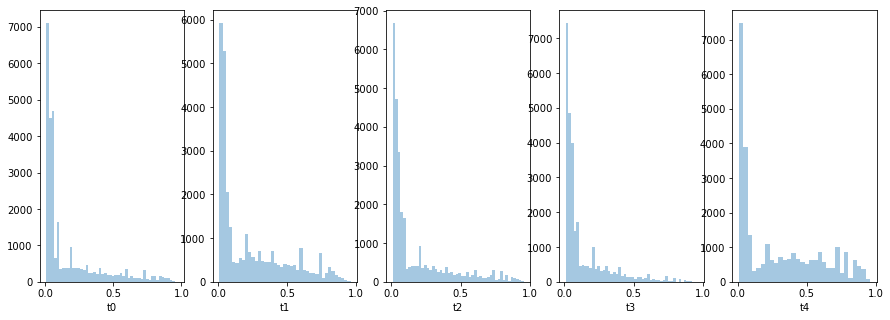

In [56]:
fig,ax = plt.subplots(1,5,figsize=(15,5))
for i in range(5):
    sns.distplot(multipardf['t'+str(i)],kde=False,ax=ax[i])

It looks like most paragraphs are a mixture of the 5 topics as well. No paragraphs predominantly belong to a single topic.    